In [43]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split 
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import matplotlib.pyplot as plt


In [44]:
%matplotlib inline  
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [45]:
df = pd.read_csv("london_merged.csv", parse_dates=['timestamp'], index_col='timestamp')

# dataset imported from kaggle https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

In [46]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [47]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [48]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

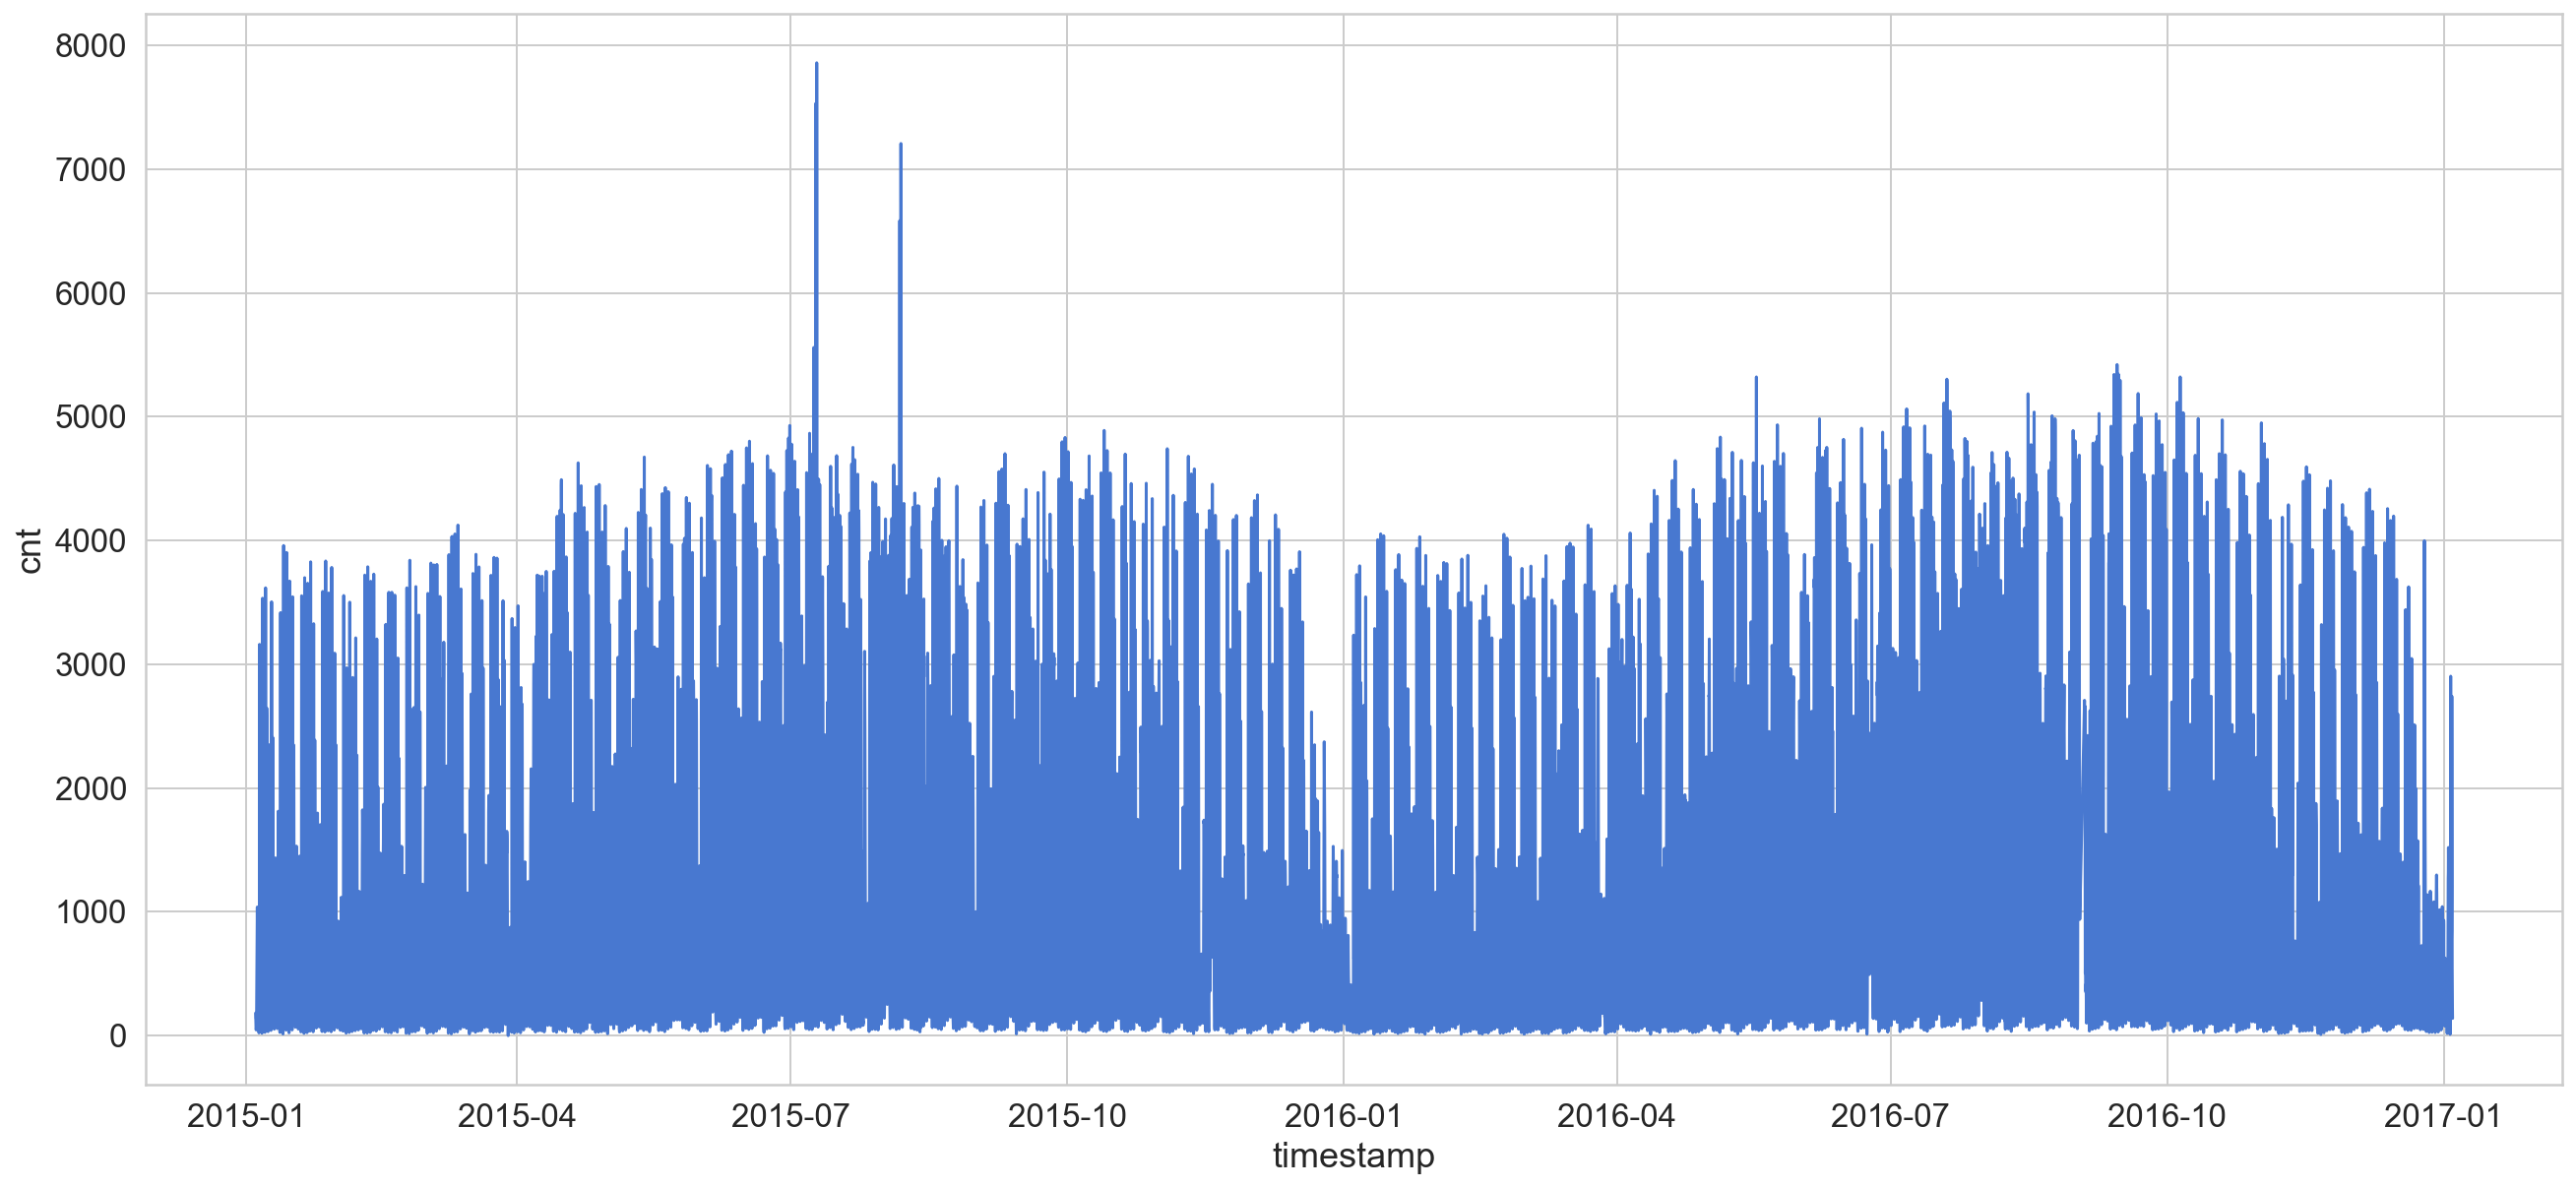

In [49]:
sns.lineplot(x=df.index, y='cnt', data=df)

In [50]:
df_by_month = df.resample('m').sum()

sns.lineplot(x=df_by_month.index, y='cnt', data=df_by_month)

# Bike demand during each month

NameError: name 'df_by_mounth' is not defined

<AxesSubplot:xlabel='hour', ylabel='cnt'>

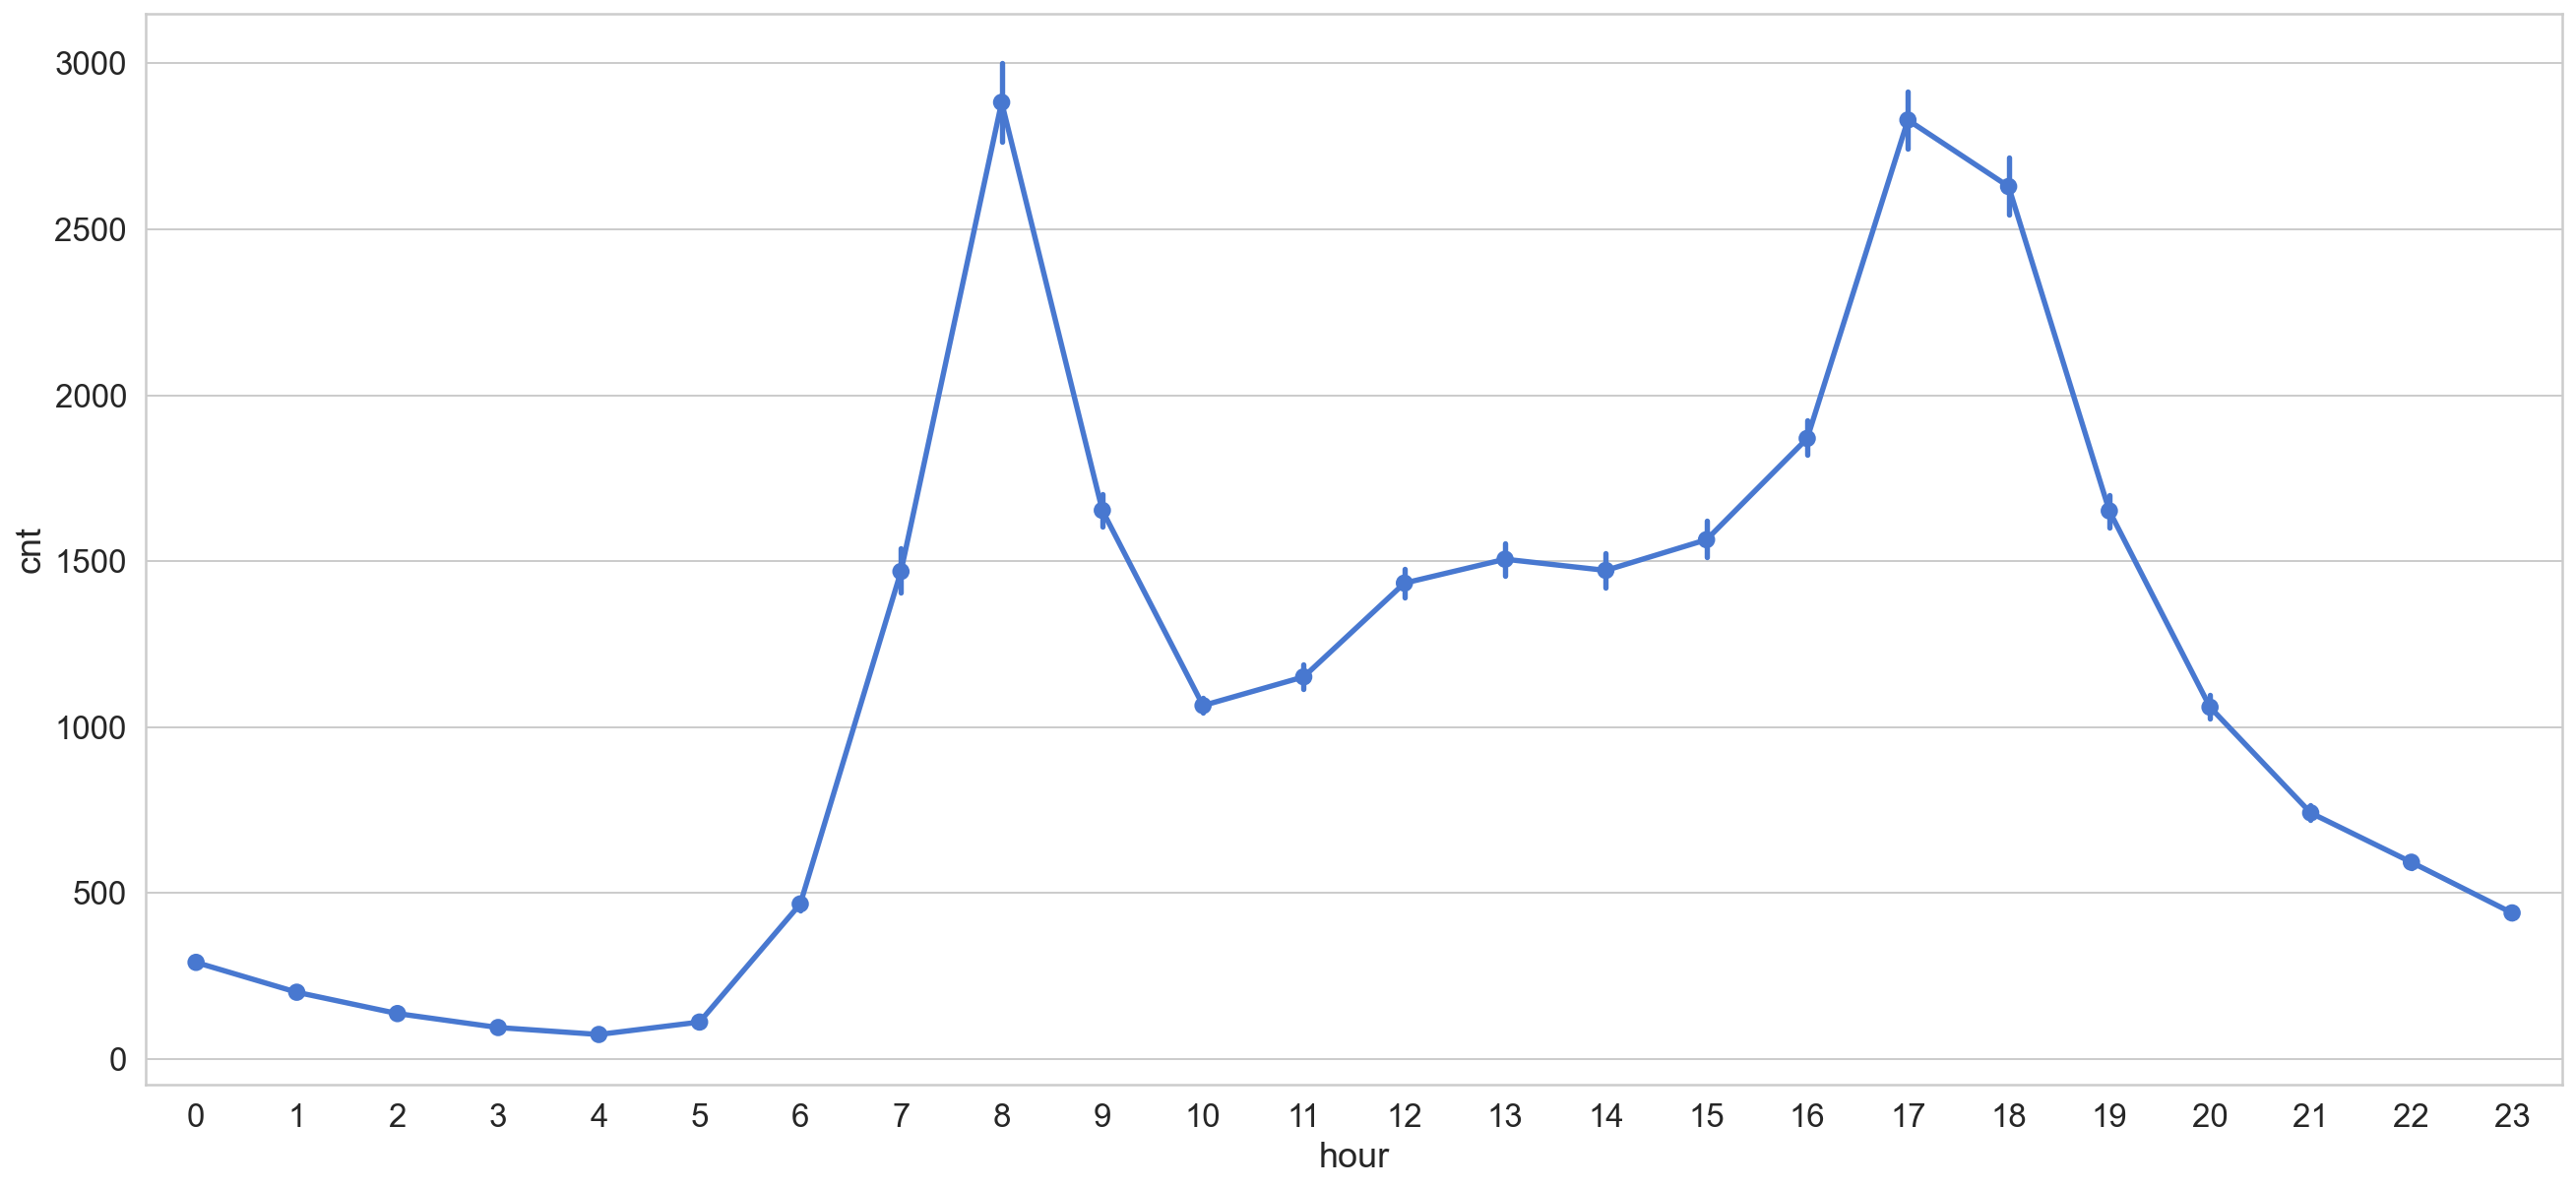

In [14]:
sns.pointplot(data=df, x='hour', y='cnt')

# Bike demand during hours of day

<AxesSubplot:xlabel='hour', ylabel='cnt'>

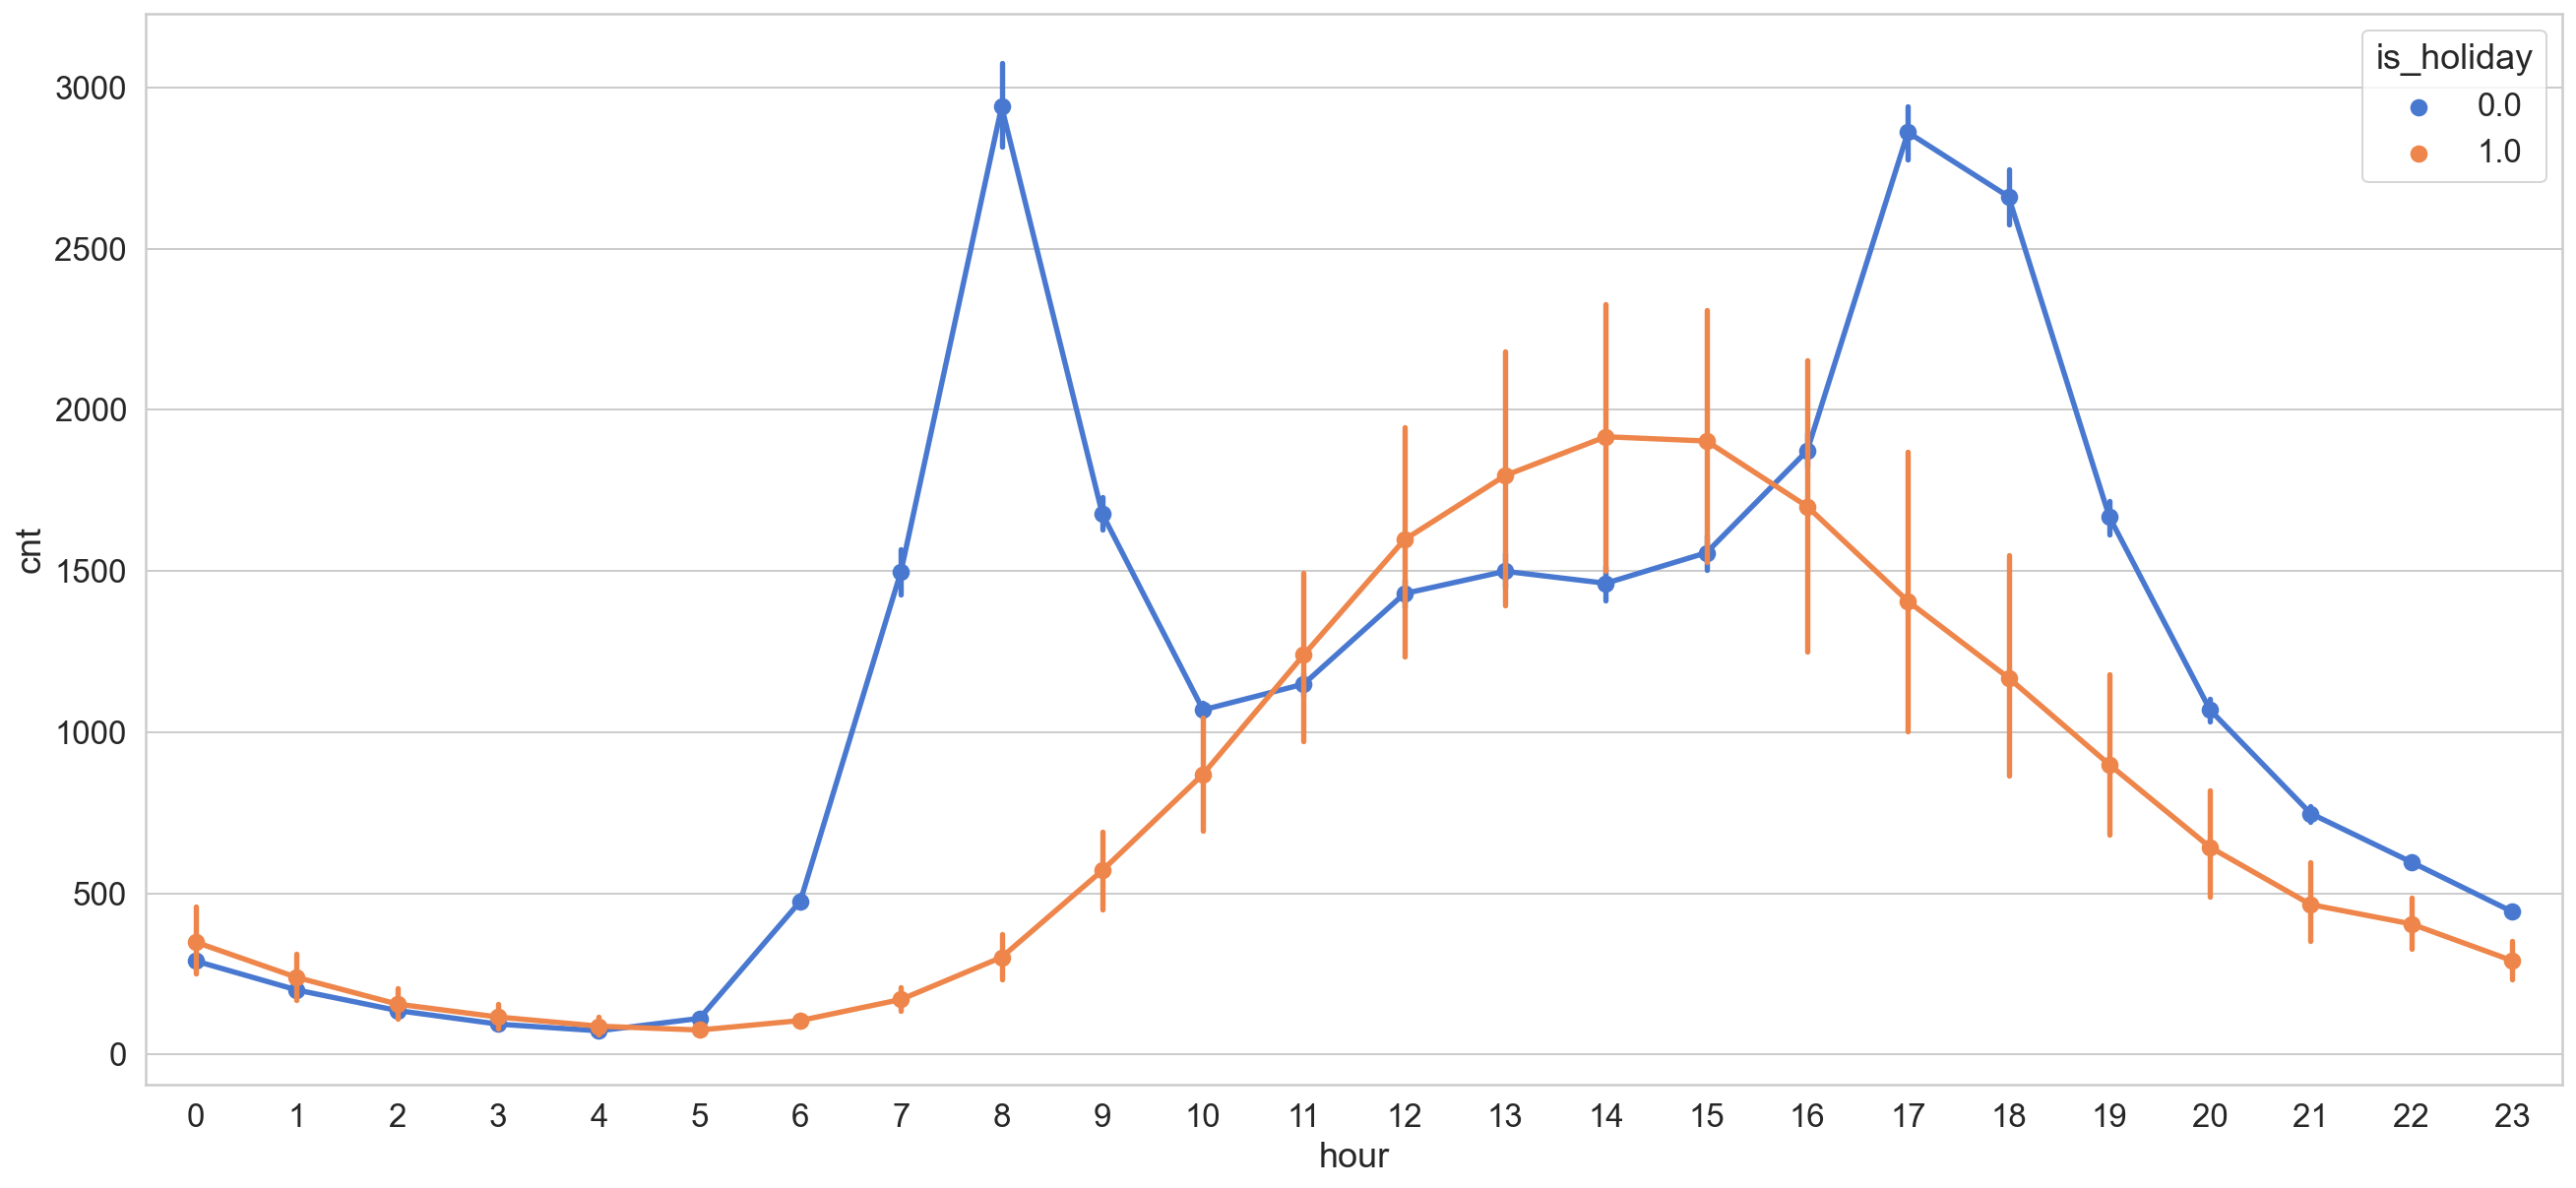

In [51]:
sns.pointplot(data=df, x='hour', y='cnt', hue ='is_holiday')

# Bike demand during hoildays and also not during holidays
# We can see spike in demand during mid day on holidays

<AxesSubplot:xlabel='day_of_week', ylabel='cnt'>

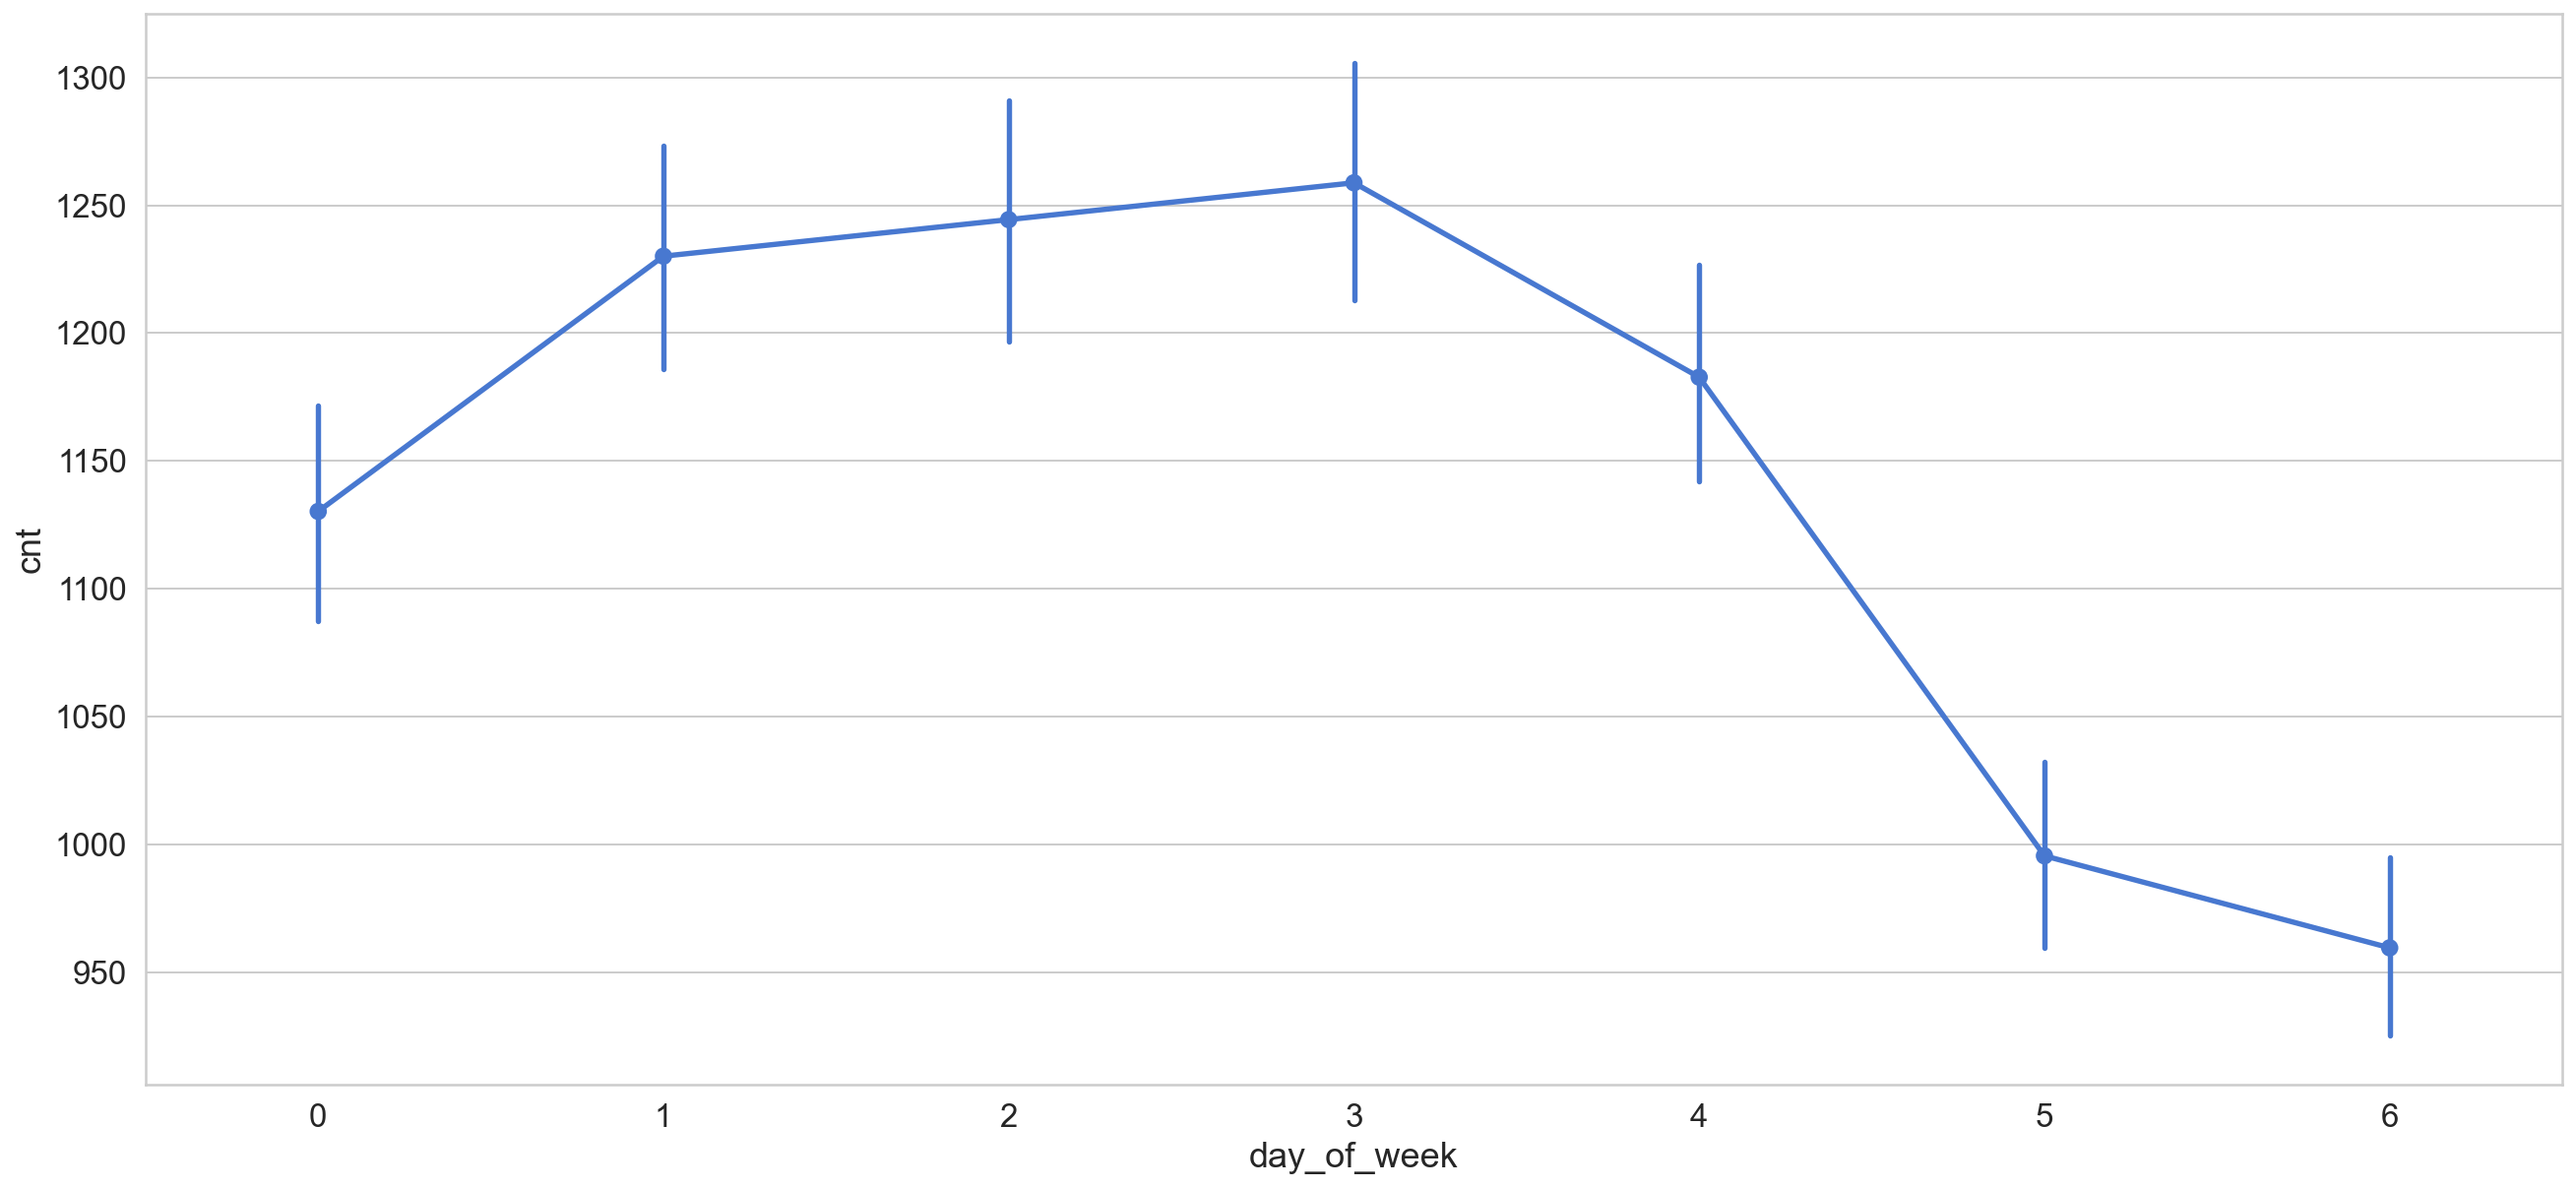

In [17]:
sns.pointplot(data=df, x='day_of_week', y='cnt')

#bike share demand on day of week. We can note less on weekend

In [18]:
# split data for training and testing

train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(len(train), len(test))

15672 1742


In [74]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

# pre-process only train data

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = f_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [19]:
# cut data into sub sequenses 

def create_dataset(x, y, time_steps=1):
    xs, ys = [], []
    for i in range(len(x) - time_steps):
        v = x.iloc[i: (i + time_steps)].to_numpy()
        xs.append(v)
        ys.append(y.iloc[i + time_steps])

        # non inclusive indexing

    return np.array(xs), np.array(ys)

In [20]:
# take 24 hrs to predict next hour

TIME_STEPS = 24

x_train, y_train = create_dataset(train, train.cnt, time_steps=TIME_STEPS)
x_test, y_test = create_dataset(test, test.cnt, time_steps=TIME_STEPS)


In [21]:
print(x_train.shape, y_train.shape)

# [samples, time_steps, features]

(15648, 24, 13) (15648,)


In [22]:
print(x_test.shape, y_test.shape)

# [samples, time_steps, features]

(1718, 24, 13) (1718,)


In [23]:
# bi directional lstm model
# looks into history and future

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            #number of neurons
            units=128,
            input_shape=(x_train.shape[1], x_train.shape[2])
        )
    )
)

# drop out 
model.add(keras.layers.Dropout(rate=0.2))
#fully connected layer with sinlge output (bike demand cnt)
model.add(keras.layers.Dense(units=1))

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
history = model.fit(
    x_train, y_train,
    # training data will be used 30 times
    epochs=5,
    # number of samples model will take in a single step
    batch_size=32,
    validation_split=0.1,
    # dont to shuffle time serices data
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 23s 51ms/step - loss: 2328980.2500 - val_loss: 3147612.0000
Epoch 2/30
441/441 [==============================] - 25s 57ms/step - loss: 2132165.2500 - val_loss: 2931486.2500
Epoch 3/30
441/441 [==============================] - 22s 50ms/step - loss: 1964582.8750 - val_loss: 2727851.5000
Epoch 4/30
441/441 [==============================] - 20s 44ms/step - loss: 1812950.0000 - val_loss: 2545738.5000
Epoch 5/30
441/441 [==============================] - 22s 49ms/step - loss: 1676317.1250 - val_loss: 2377760.7500
Epoch 6/30
  6/441 [..............................] - ETA: 20s - loss: 652668.2500

KeyboardInterrupt: 

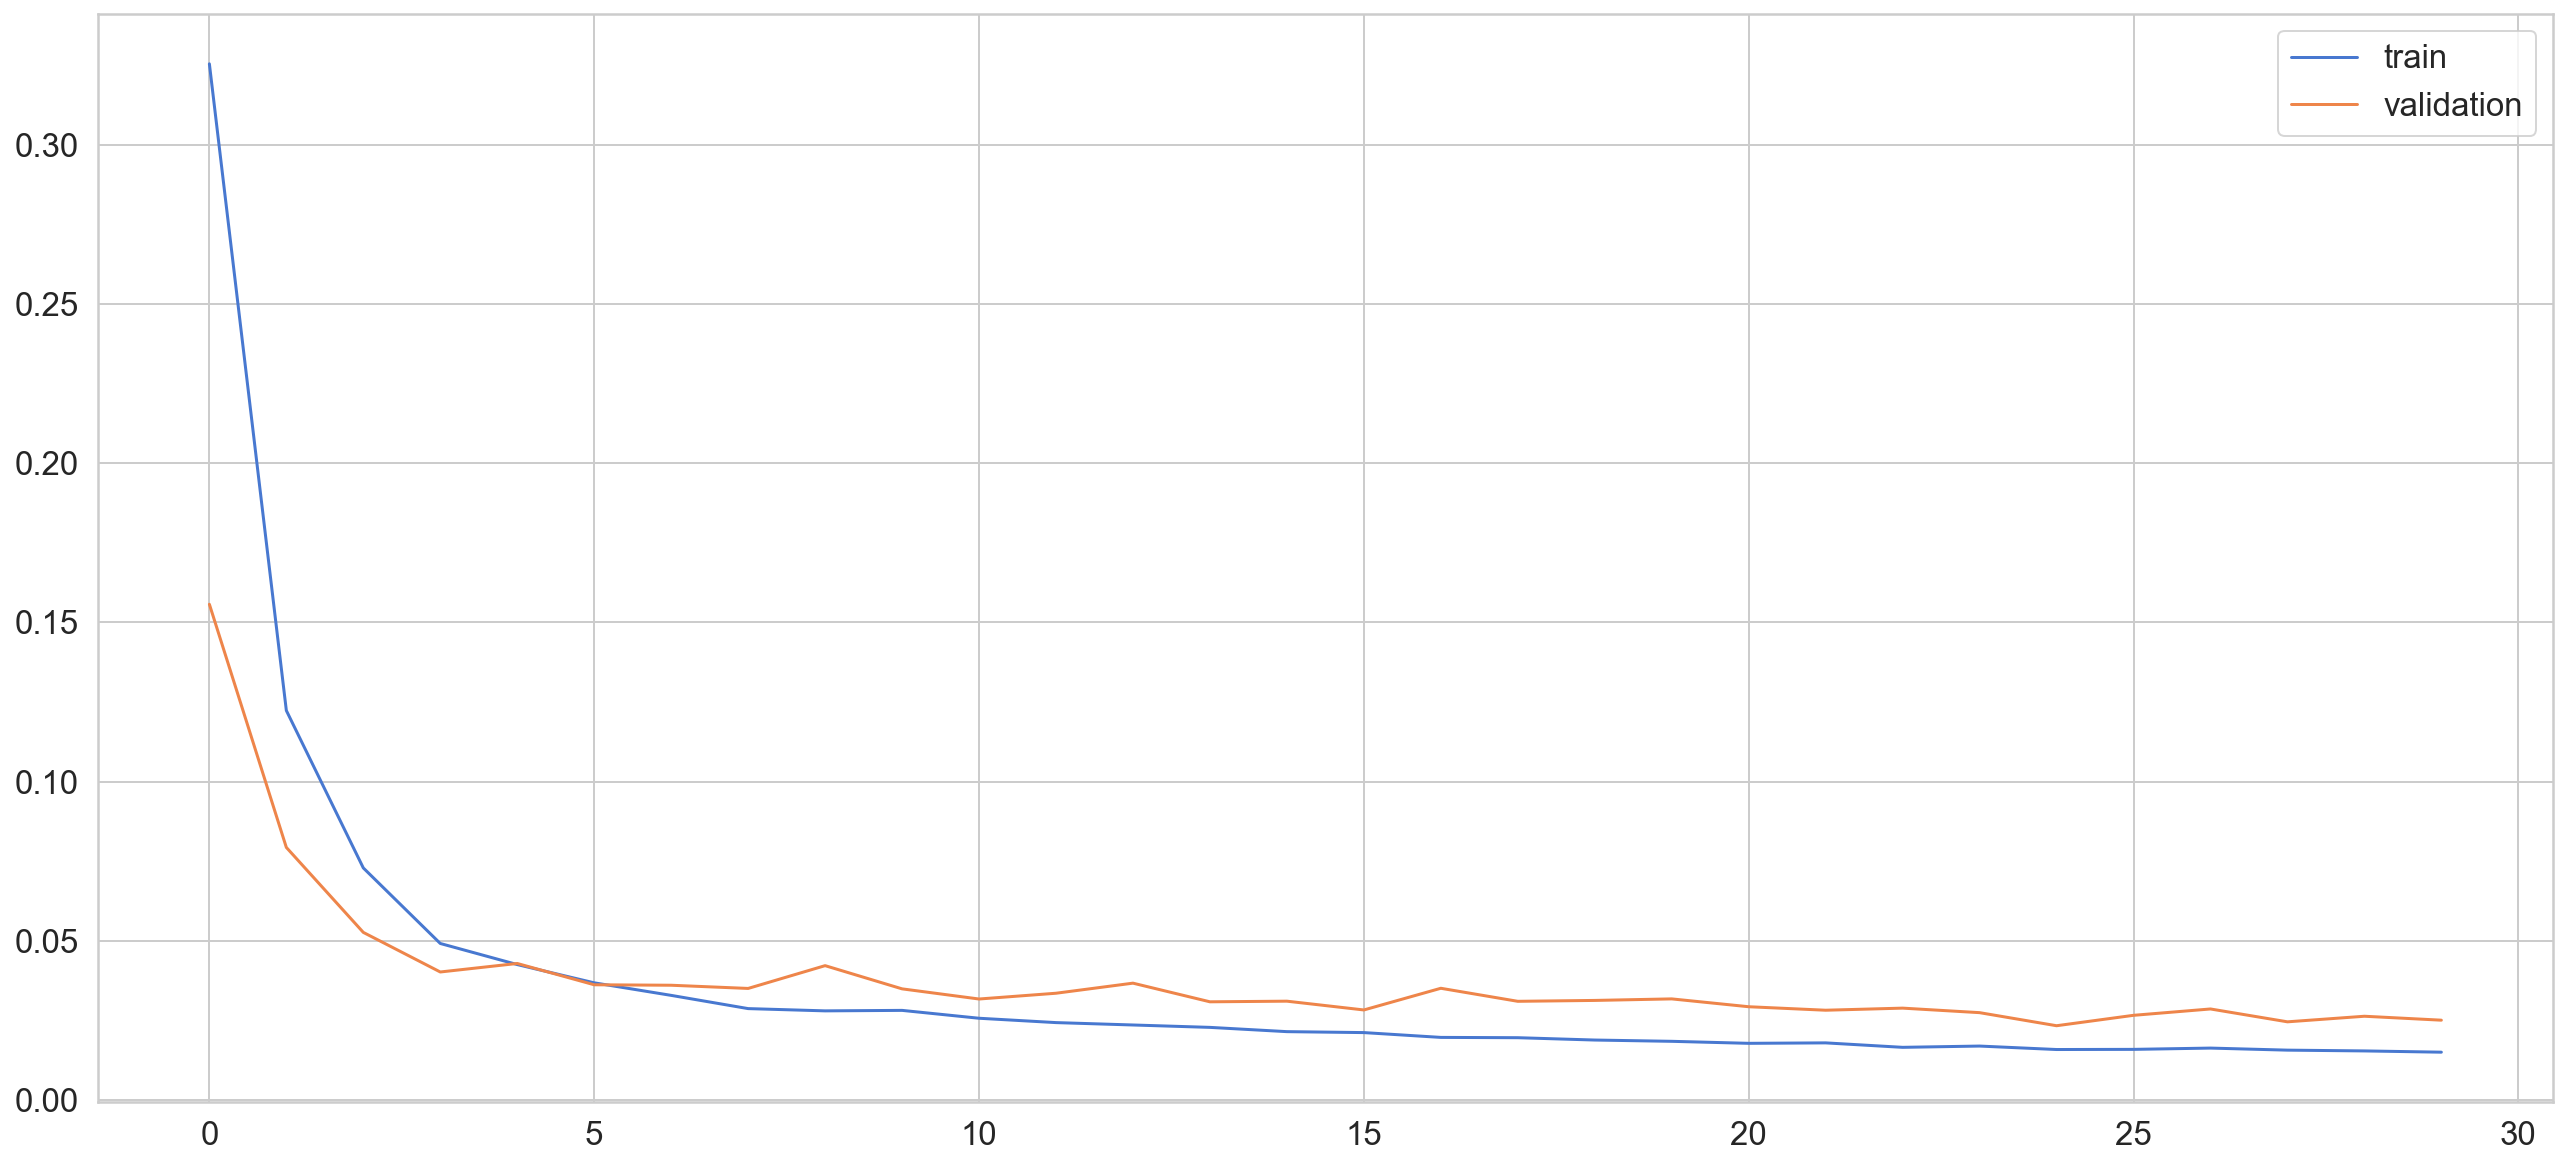

In [117]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

# we can see how acurate our model is

In [119]:
y_pred  = model.predict(x_test)

In [124]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

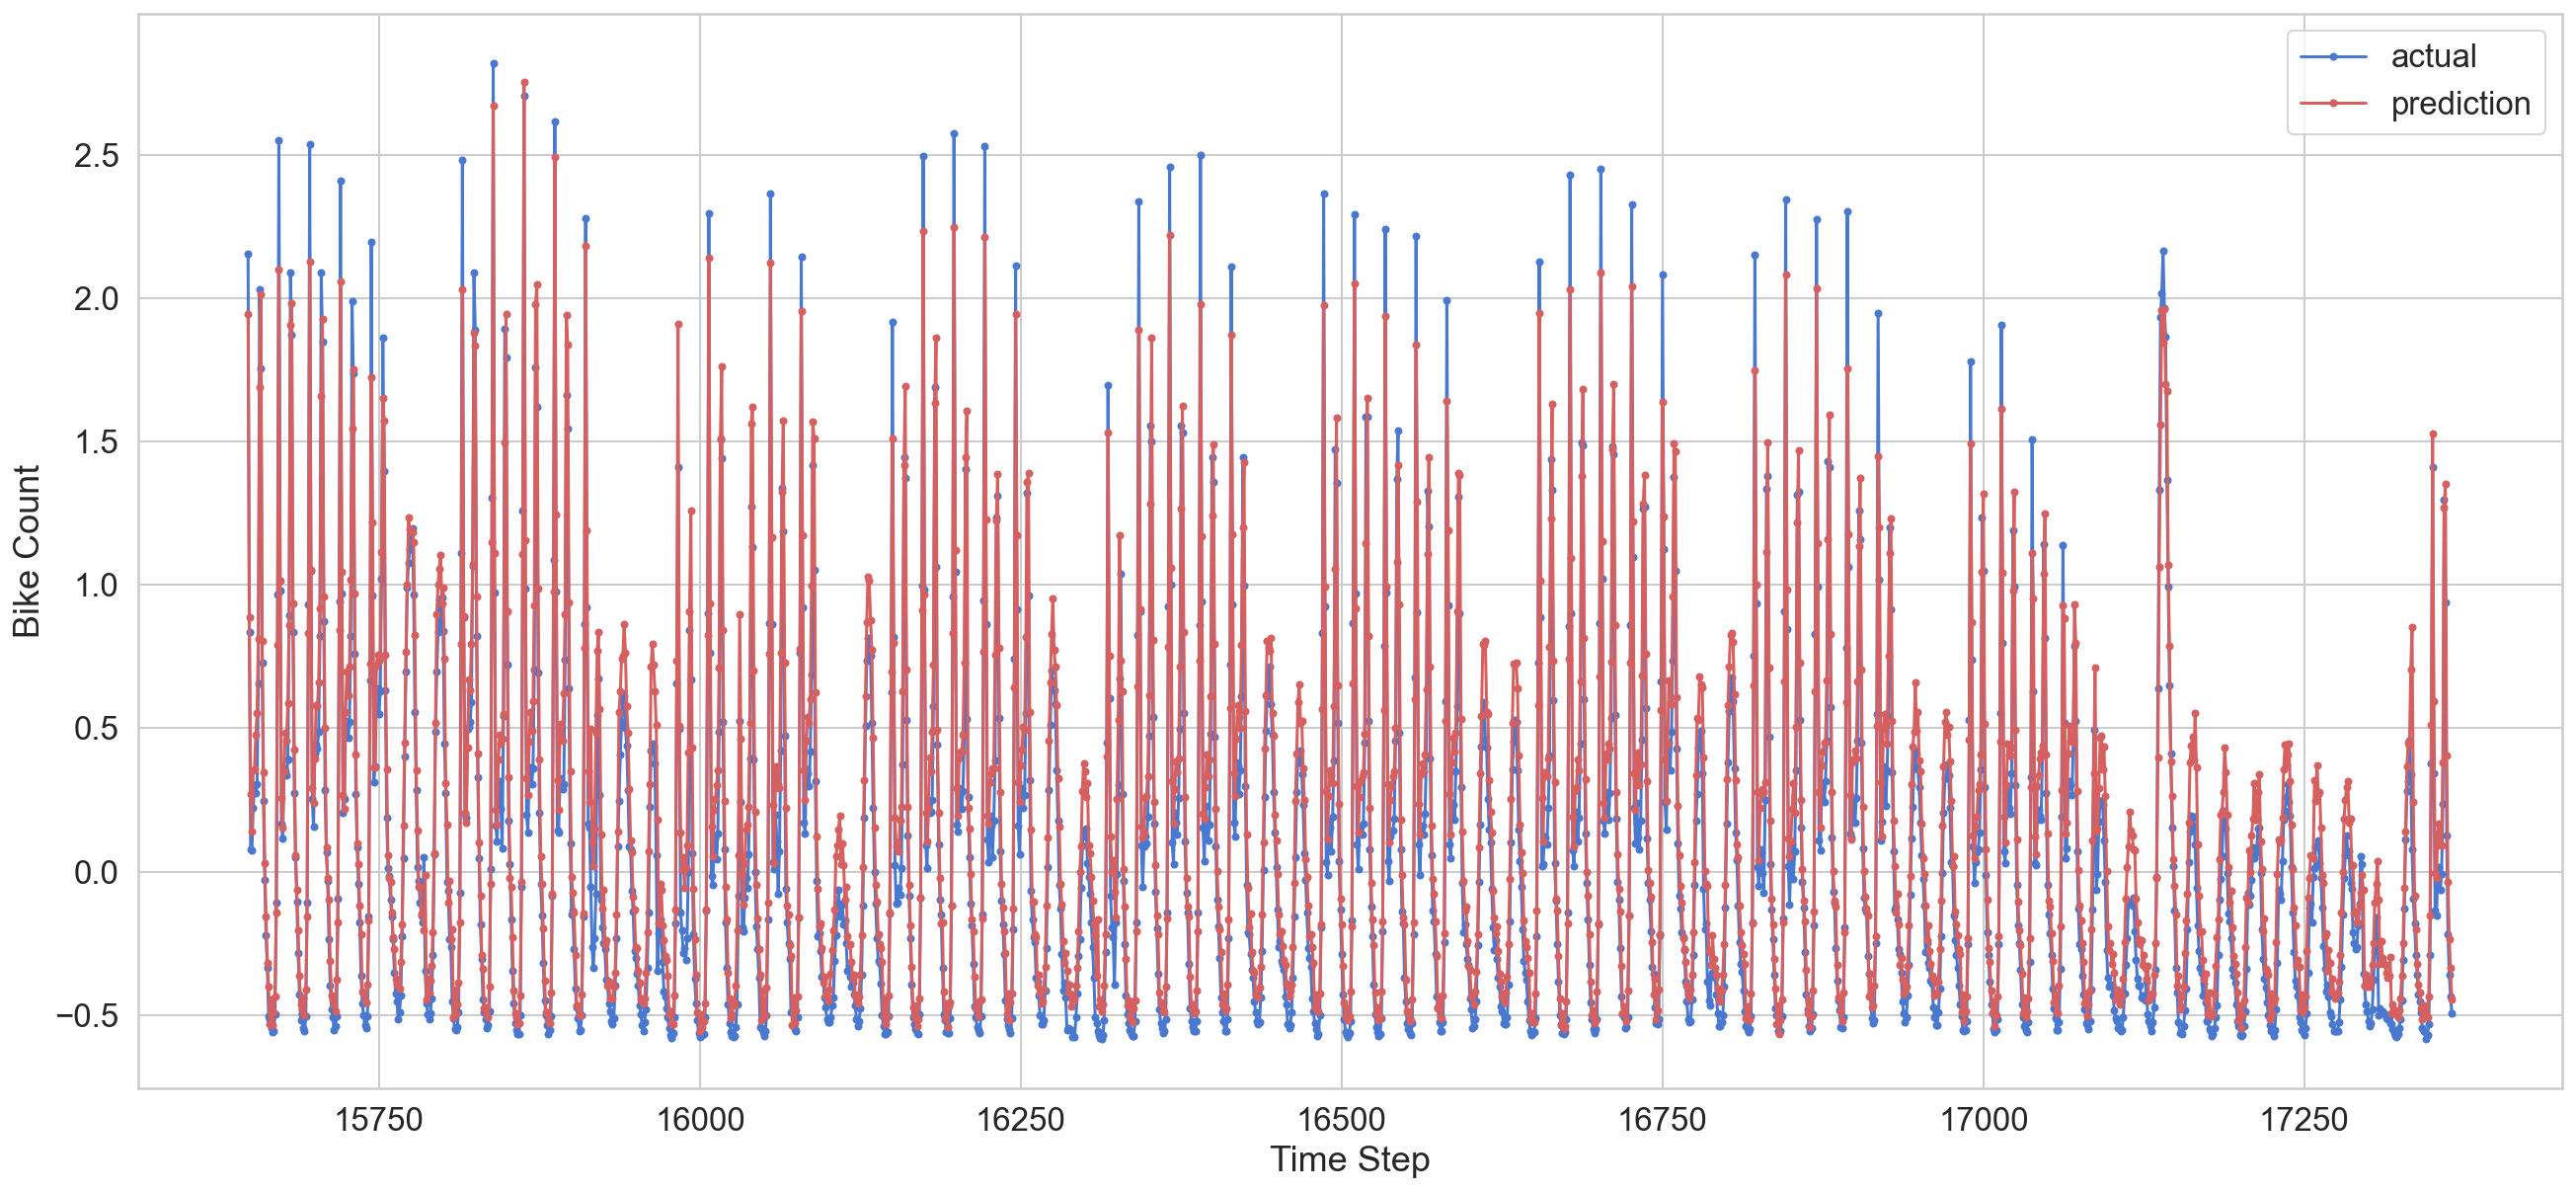

In [130]:
#plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', marker='.', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# predictions vs actual